In [1]:
import tifffile
import numpy as np
from matplotlib import pyplot as plt
import os
import napari
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit
from scipy.ndimage import zoom
from napari.utils.notifications import show_info
from natsort import os_sorted
import tkinter
from tkinter import filedialog
from scipy import ndimage
import cv2
from scipy.ndimage import gaussian_filter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle
import json

In [2]:
def fwhm_along_axis(y, spacing, plot = False):
    # Maximum normalization
    y_norm = [i/max(y) for i in y]
    # create x values for plot based on the intensity values y considering the spacing
    x = [(i) * spacing for i in range(len(y_norm))]

    # find fwhm of plot
    spline = UnivariateSpline(x, y_norm-np.max(y_norm)/2, s=0)
    r1, r2 = spline.roots()
    fwhm = abs(abs(r1) - abs(r2))

    # return fwhm
    return [fwhm]


def get_fwhm(bbox, spacing_xy, spacing_z):
    # find max intensity
    max_coor = np.unravel_index(np.argmax(bbox), bbox.shape)
    xy_maxint = np.max(bbox, axis=0)
    xz_maxint = np.max(bbox, axis=1)
    # get intensity lines
    y_line = xy_maxint[int(max_coor[1]),:]
    x_line = xy_maxint[:,int(max_coor[2])]
    z_line = xz_maxint[:,int(max_coor[2])]
    # get fwhm
    fwhm_x = fwhm_along_axis(x_line, spacing_xy)
    fwhm_y = fwhm_along_axis(y_line, spacing_xy)
    fwhm_z = fwhm_along_axis(z_line, spacing_z)
    # return fwhm
    return [fwhm_x[0], fwhm_y[0], fwhm_z[0]], max_coor[0]
    

def apply_bbox_and_fwhm(img, psf, bbox_size = 10, spacing_xy = 0.06484, spacing_z = 0.06484):
    
    # make bounding box
    upper = [int(psf[0] + bbox_size/2), int(psf[1] + bbox_size/2)]
    lower = [int(psf[0] - bbox_size/2), int(psf[1] - bbox_size/2)]
    bbox = img[:,lower[0]:upper[0], lower[1]:upper[1]]
    fwhm_list, coor_z = get_fwhm(bbox, spacing_xy, spacing_z)
    
    return np.array(fwhm_list)*1000, coor_z

# extracting all the beads
def connected_component_analysis(stack, threshold = 10000):
    max_plane = np.max(stack, axis = 0)
    binary_mask = (max_plane >= threshold).astype(np.uint8)
    # connected component analysis
    labeled_mask, num_features = ndimage.label(binary_mask)
    centroids = ndimage.center_of_mass(binary_mask, labeled_mask, range(1, num_features + 1))

    return centroids

def load_datasets(paths):
    stacks = []
    for path in paths:
        stack = tifffile.imread(path)
        stacks.append(stack)
    return np.array(stacks)

def shift_stack_lateral(stack, xy_shift=(0,0)):
    rolled = np.roll(stack, xy_shift[0], axis=[0])
    shift = np.roll(rolled,xy_shift[1], axis=[1])   


# Detect PSFs automatically

In [3]:
paths = ['C:/Users/alm/Documents/ImSwitchConfig/recordings/2024-08-23/psf_dualcolor_slit_open_galvo_on_rec_thorlabscam_reshaped/tile_1_channel_0.tif',
         'C:/Users/alm/Documents/ImSwitchConfig/recordings/2024-08-23/psf_dualcolor_slit_open_galvo_on_rec_thorlabscam_reshaped/tile_1_channel_1.tif']
#paths = ['C:/Users/alm/Documents/ImSwitchConfig/recordings/2024-08-30/beads_test_rec_thorlabscam_3.tif']
channels = ['ex 488 em 525','ex 561 em 610']

stacks = load_datasets(paths)
#home = 'C:/Users/alm/Documents/ImSwitchConfig/recordings/2024-08-30/beads_test_rec_thorlabscam_3/'
#files = os_sorted(os.listdir(home))
#stack =  np.array([tifffile.imread(home + file) for file in files if file.endswith('.tif')])
#metadata_file = home + 'metadata.json'
#try:
#    metadata = json.load(open(metadata_file))
#    
#except FileNotFoundError:
#    print('No metadata file found')
#    
print(stacks.shape)

(2, 300, 2160, 4096)


In [4]:
viewer = napari.Viewer()
for i, stack in enumerate(stacks):
    viewer.add_image(stack, name = channels[i])

In [4]:
# run PSF analysis on mf-sim PSF and widefield PSF detecting the PSFs automatically
#TODO
stack = stacks[0]
wf_shift = stacks[1]
print(stack.shape)
all_fwhm = []
all_fwhm_wf = []
points = []

for point in connected_component_analysis(stack, threshold=50):
    try:
        fwhm_xyz, coor_z = apply_bbox_and_fwhm(stack, point, bbox_size=20, spacing_xy=0.345, spacing_z=1.1261)
        fwhm_xyz_wf, coor_z_wf = apply_bbox_and_fwhm(wf_shift, point, bbox_size=20, spacing_xy=0.345, spacing_z=1.1261)
        all_fwhm.append(fwhm_xyz)
        all_fwhm_wf.append(fwhm_xyz_wf)
        points.append([coor_z, point[0], point[1]])
    except ValueError:
        continue

(300, 2160, 4096)


In [5]:
ch1 = channels[0]
ch2 = channels[1]

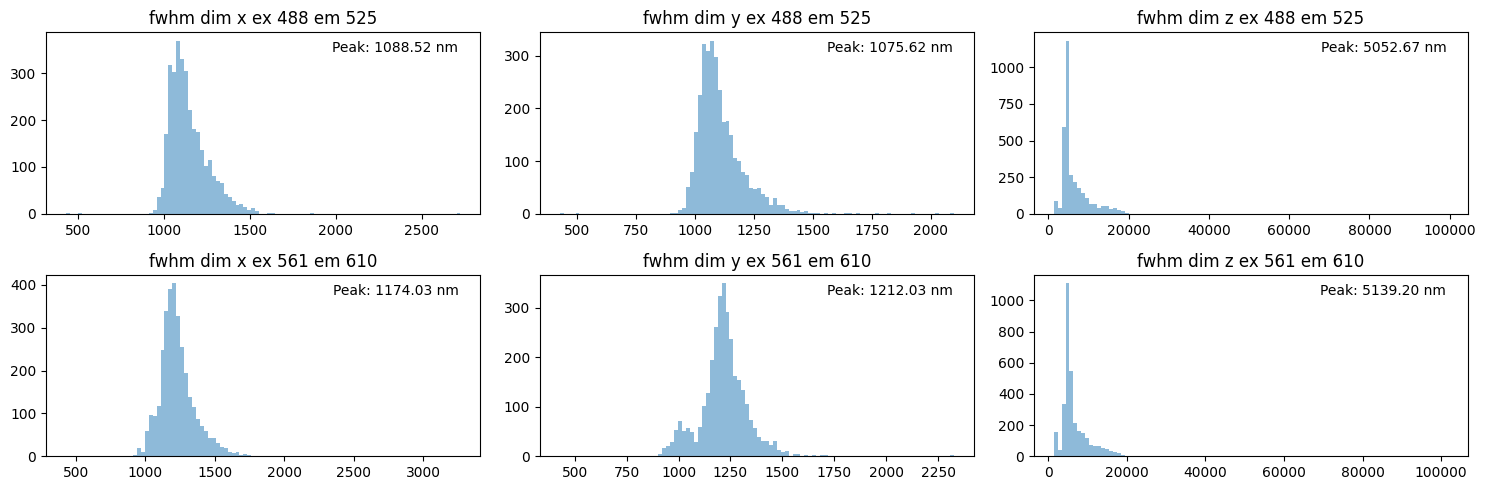

In [6]:
# plot histogram of fwhm values
all_fwhm = np.array(all_fwhm)
all_fwhm_wf = np.array(all_fwhm_wf)
bins = 100
# all_fwhm shape (3228, 3)
def add_peak_textbox(ax, data, bins=bins):
    hist, bin_edges = np.histogram(data, bins=40)  # Use the same number of bins as in the plot
    peak_bin_index = np.argmax(hist)
    peak_value = (bin_edges[peak_bin_index] + bin_edges[peak_bin_index + 1]) / 2  # Use the middle of the bin
    ax.text(0.95, 0.95, f'Peak: {peak_value:.2f} nm', 
            transform=ax.transAxes, 
            horizontalalignment='right', 
            verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

axes = ['x', 'y', 'z']
fig, axs = plt.subplots(2, 3, figsize=(15, 5))
for dims in range(all_fwhm.shape[1]):
    axs[0,dims].hist(all_fwhm[:,dims], bins=bins, alpha=0.5, label='ch1')
    axs[0,dims].set_title(f'fwhm dim {axes[dims]} '+ ch1)
    add_peak_textbox(axs[0, dims], all_fwhm[:, dims])
    axs[1,dims].hist(all_fwhm_wf[:,dims], bins=bins, alpha=0.5, label='ch2')
    axs[1,dims].set_title(f'fwhm dim {axes[dims]} '+ ch2)  
    add_peak_textbox(axs[1, dims], all_fwhm_wf[:, dims])
plt.tight_layout()
plt.show()

In [14]:
# filter psfs
max_fwhm_x_plus_y = 4000
max_fwhm_z = 4000
min_fwhm_z = 2500

# run PSF analysis on mf-sim PSF and widefield PSF detecting the PSFs automatically
filtered_fwhm_ch1 = []
filtered_fwhm_ch2 = []
filtered_points = []
for i in range(len(points)):
    fwhm_x = all_fwhm[i, 0]
    fwhm_y = all_fwhm[i, 1]
    fwhm_z = all_fwhm[i, 2]
    fwhm_x_wf = all_fwhm_wf[i, 0]
    fwhm_y_wf = all_fwhm_wf[i, 1]
    fwhm_z_wf = all_fwhm_wf[i, 2]
    if fwhm_x + fwhm_y < max_fwhm_x_plus_y and fwhm_z < max_fwhm_z and fwhm_z > min_fwhm_z:
        filtered_fwhm_ch1.append([fwhm_x, fwhm_y, fwhm_z])
        filtered_fwhm_ch2.append([fwhm_x_wf, fwhm_y_wf, fwhm_z_wf])
        filtered_points.append(points[i])

filtered_fwhm_ch1 = np.array(filtered_fwhm_ch1)
avg = np.mean(filtered_fwhm_ch1, axis=0) 
sd = np.std(filtered_fwhm_ch1, axis=0) 
print('- ch0, Number of beads selected: {}'.format(filtered_fwhm_ch1.shape[0]))
print('- X FWHM is {:.4f} +/- {:4f} nm'.format(avg[1], sd[1]))
print('- Y FWHM is {:.4f} +/- {:4f} nm'.format(avg[0], sd[0]))
print('- Z FWHM is {:.4f} +/- {:4f} nm'.format(avg[2], sd[2]))

filtered_fwhm_ch2 = np.array(filtered_fwhm_ch2)
avg_wf = np.mean(filtered_fwhm_ch2, axis=0) 
sd_wf = np.std(filtered_fwhm_ch2, axis=0) 
print('- ch1, Number of beads selected: {}'.format(filtered_fwhm_ch2.shape[0]))
print('- X FWHM is {:.4f} +/- {:4f} nm'.format(avg_wf[1], sd_wf[1]))
print('- Y FWHM is {:.4f} +/- {:4f} nm'.format(avg_wf[0], sd_wf[0]))
print('- Z FWHM is {:.4f} +/- {:4f} nm'.format(avg_wf[2], sd_wf[2]))

# add psfs to napari
#viewer.add_points(points)

- ch0, Number of beads selected: 282
- X FWHM is 1039.5937 +/- 50.344482 nm
- Y FWHM is 1076.4600 +/- 61.697332 nm
- Z FWHM is 3644.5642 +/- 294.012493 nm
- ch1, Number of beads selected: 282
- X FWHM is 1078.2205 +/- 109.785414 nm
- Y FWHM is 1108.7269 +/- 89.806578 nm
- Z FWHM is 3841.6691 +/- 698.948600 nm


Axial PSF within ROI: 3629.103907450256, ROI shape: (4096, 648)


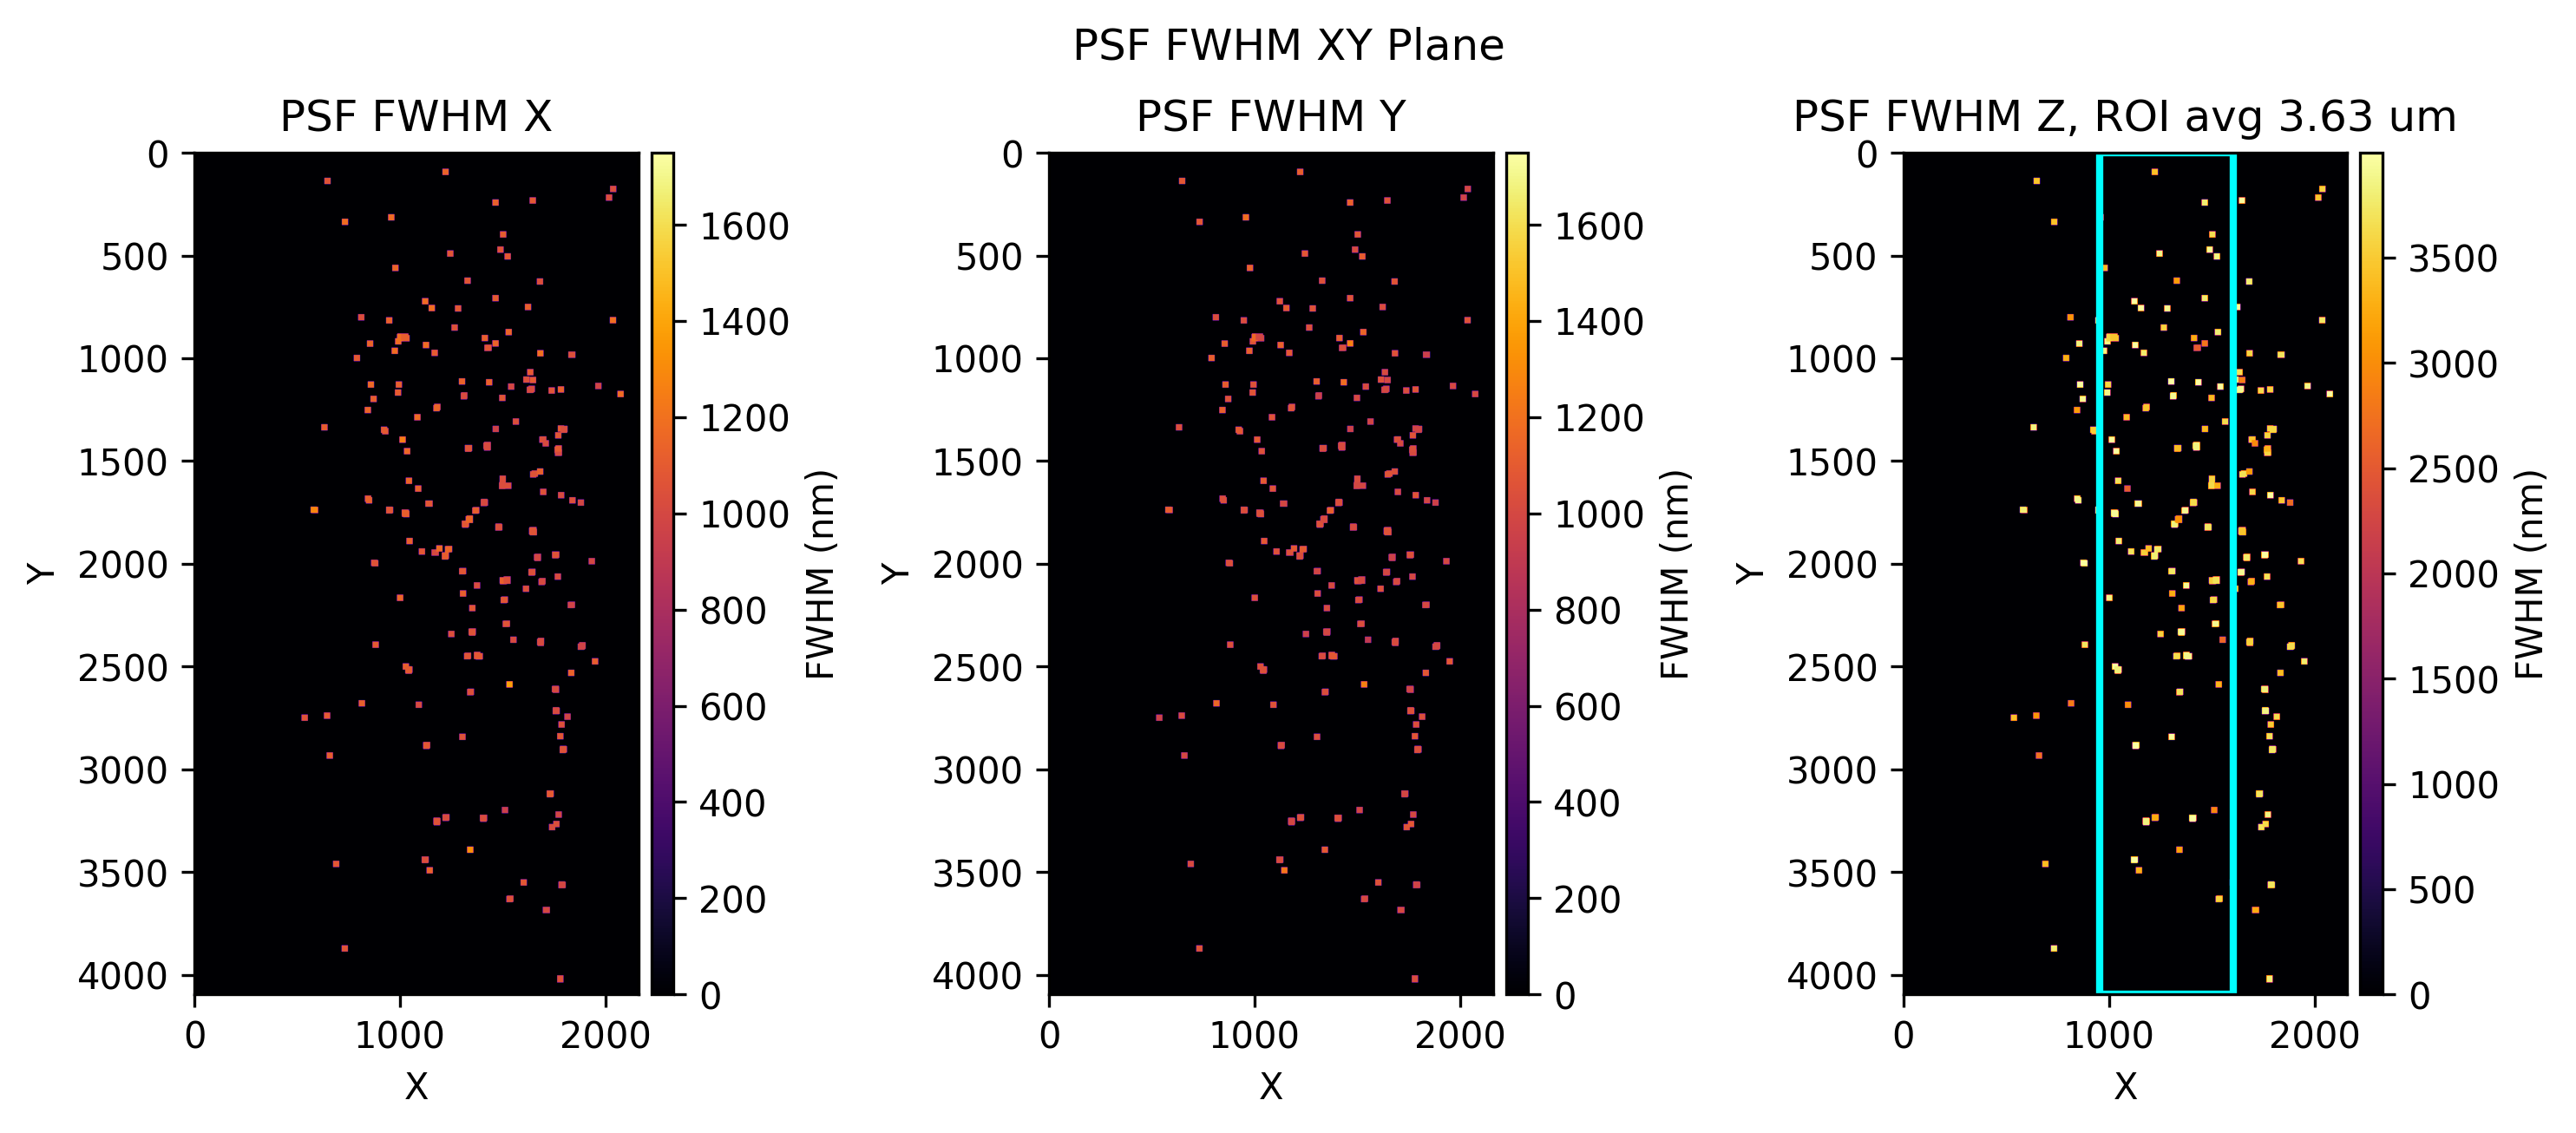

In [15]:
z = [i[0] for i in filtered_points]
y = [i[1] for i in filtered_points]
x = [i[2] for i in filtered_points]
import scipy

def add_square(grid, x, y, value, size=30):
    x_start = max(0, x - size // 2)
    x_end = min(grid.shape[1], x + size // 2 + 1)
    y_start = max(0, y - size // 2)
    y_end = min(grid.shape[0], y + size // 2 + 1)
    grid[y_start:y_end, x_start:x_end] = value

z_max, y_max, x_max = stack.shape       #300 2160 4096

def plot(x, y, x_shape, y_shape, all_fwhm, title='psf',ytitle=0.63, ROI_scale=None, xshift=0, spotsize=30, scale_x = 1):

    fig, axs = plt.subplots(1, 3, figsize=(10, 15), dpi=300)
    fig.suptitle(title, y=ytitle)
    dim = ['X', 'Y', 'Z']
    for dims in range(all_fwhm.shape[1]):
        grid = np.zeros((x_shape, y_shape))
        for i in range(len(x)):
            add_square(grid, int(x[i]), int(y[i]), all_fwhm[i, dims], size=spotsize)
        scaled_grid = scipy.ndimage.zoom(grid, (1, scale_x), order=1)
        if dims < 2:
            im = axs[dims].imshow(scaled_grid, cmap='inferno', vmin=0, vmax=1750)#, origin='lower', extent=[0.5, x_max+0.5, 0.5, y_max+0.5])
        else:
            im = axs[dims].imshow(scaled_grid, cmap='inferno')
        axs[dims].set_xlabel('X')
        axs[dims].set_ylabel('Y')
        divider = make_axes_locatable(axs[dims])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax, label='FWHM (nm)')
        if dims == 2 and ROI_scale!=None:   
            xy_tuple = (int(y_shape*0.5)-int((y_shape*ROI_scale)/2) + xshift,0)
            roi_values = grid[0:x_shape,xy_tuple[0]:xy_tuple[0]+int(y_shape*ROI_scale)]
            non_zero_values = roi_values[roi_values > 0]

            if len(non_zero_values) > 0:
                roi_average = np.mean(non_zero_values)
            else:
                roi_average = 0  
            axs[dims].set_title(f'PSF FWHM {dim[dims]}, ROI avg {(roi_average/1000):.2f} um')
            print(f'Axial PSF within ROI: {roi_average}, ROI shape: {roi_values.shape}')
            rect = Rectangle(xy_tuple, int(y_shape*ROI_scale), x_shape,
                             linewidth=2, edgecolor='cyan', facecolor='none')
            axs[dims].add_patch(rect)
        else:
            axs[dims].set_title('PSF FWHM ' + dim[dims])
    fig.tight_layout()
    plt.show()

plot(y,x,x_max, y_max, filtered_fwhm_ch1, title='PSF FWHM XY Plane', ytitle=0.63, ROI_scale=0.3, xshift=200)

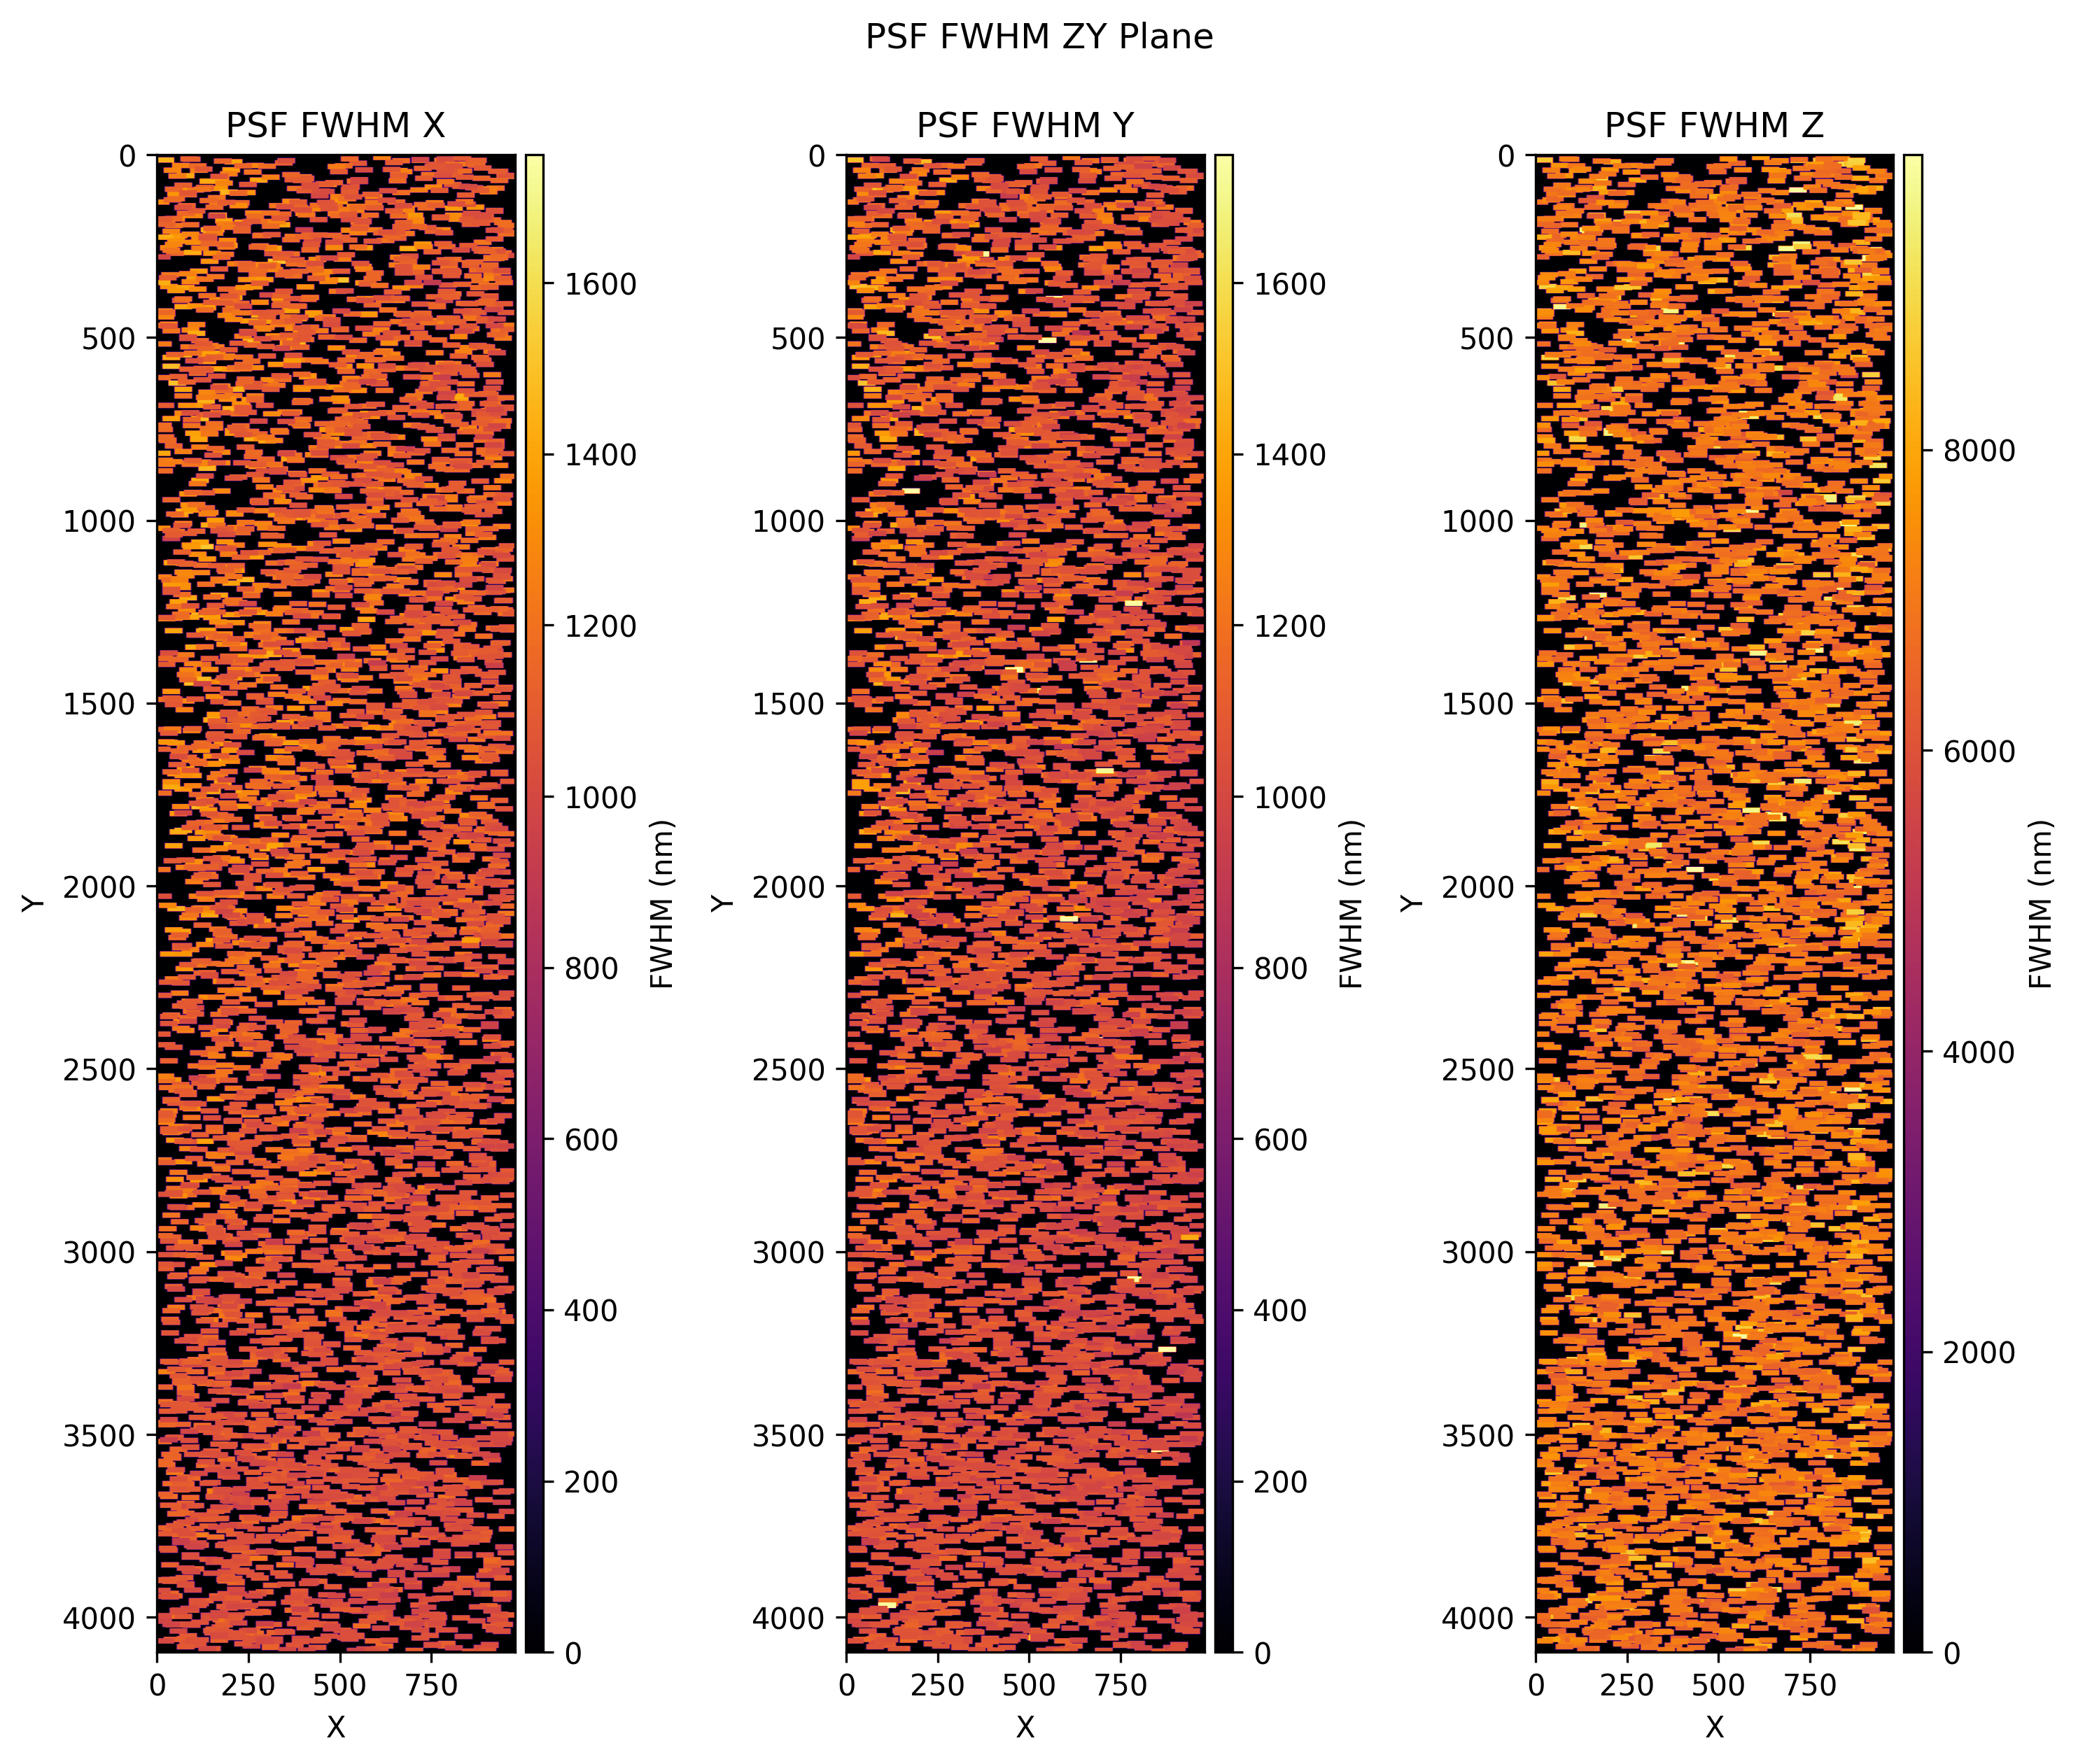

In [9]:
plot(z,x,x_max, z_max, filtered_fwhm_ch1, title='PSF FWHM ZY Plane', ytitle=0.77, spotsize = 15, scale_x=(1.1261/0.345))#, ROI_scale=0.4, xshift=180)

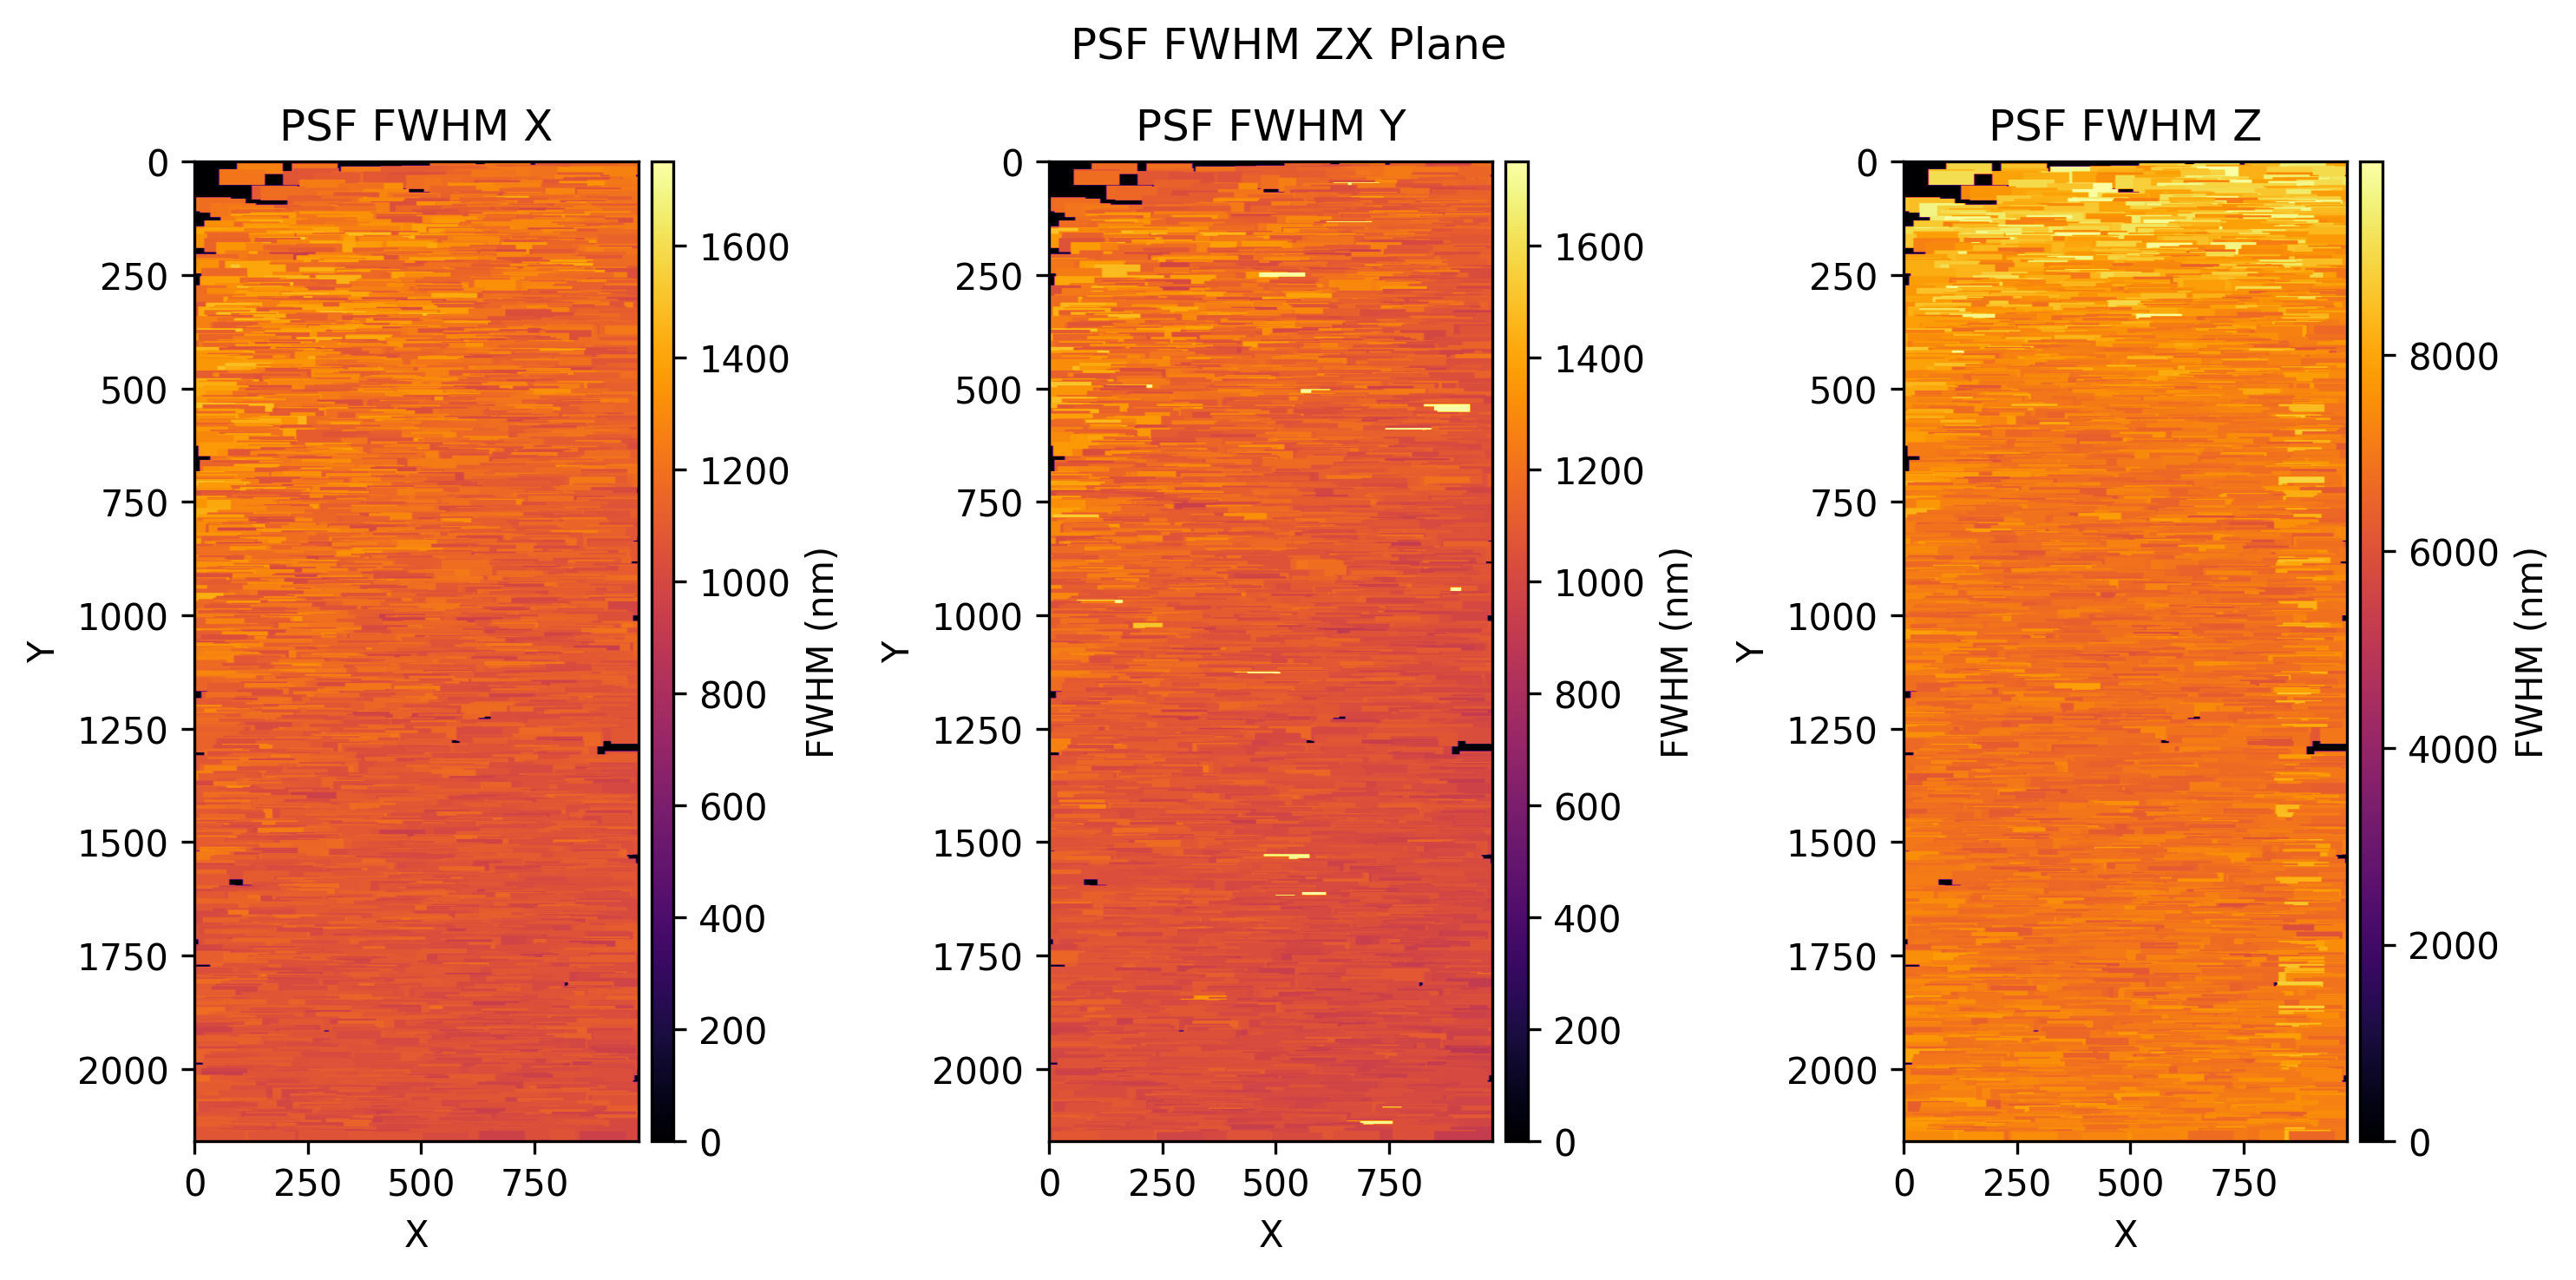

In [10]:
plot(z,y,y_max, z_max, filtered_fwhm_ch1, title='PSF FWHM ZX Plane', ytitle=0.65, scale_x=(1.1261/0.345))#, ROI_scale=0.4, xshift=180)
    

## open

- ch0, Number of beads selected: 148
- X FWHM is 1032.7276 +/- 32.412016 nm
- Y FWHM is 1066.3471 +/- 42.057674 nm
- Z FWHM is 3775.9055 +/- 851.555637 nm
- ch1, Number of beads selected: 148
- X FWHM is 1016.1459 +/- 39.939394 nm
- Y FWHM is 1054.5272 +/- 43.497806 nm
- Z FWHM is 3530.8708 +/- 1083.448406 nm

## closed

- ch0, Number of beads selected: 65
- X FWHM is 1028.9332 +/- 37.861519 nm
- Y FWHM is 1068.4737 +/- 39.110956 nm
- Z FWHM is 6994.3048 +/- 352.527752 nm
- ch1, Number of beads selected: 65
- X FWHM is 1081.4379 +/- 43.590500 nm
- Y FWHM is 1072.6811 +/- 39.443397 nm
- Z FWHM is 7440.6675 +/- 569.794662 nm

### TODO

- show fwhm per plane
- crop FOV for open slit